In [1]:
import requests as req
from model import Model
from datetime import datetime, time
import pandas as pd
from pandas_market_calendars import get_calendar
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
import pyfolio as pf
%matplotlib inline

Using TensorFlow backend.


In [238]:
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use(['seaborn'])

In [2]:
# resp = req.get('http://localhost/predict/{}/2015-01-05'.format(ticker)).json()
# resp['long_prediction']

In [3]:
def YMD(d:datetime):
    return d.strftime('%Y-%m-%d')

In [227]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.full_prediction = req.get('http://localhost/predict-range/{}/{}/{}'.format(ticker, YMD(from_date), YMD(to_date))).json()
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        self.order = None
    
    def next(self):
        if self.order:
            return
        
        if not self.position:
            try:
                today = self.datas[0].datetime.date(-1).isoformat()
                pred = self.full_prediction[today]
                if pred[0] > entry_percentage:
                    self.log('predicted long')
                    self.order = self.buy(exectype=bt.Order.Close)
                elif pred[1] > entry_percentage:
                    self.log('predicted short')
                    self.order = self.sell(exectype=bt.Order.Close)
            except Exception as e:
                self.log(e)
        else:
            if len(self) >= (self.bar_executed + 1):
                self.order = self.close(exectype=bt.Order.Close)

In [280]:
from_date = datetime(2015, 1, 1)
to_date = datetime(2017, 1, 1)
entry_percentage = 0.58
ticker = 'TEVA'

In [272]:
cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceData(
    dataname=ticker,
    fromdate=from_date,
    todate=to_date,
    reverse=False)

cerebro.adddata(data)
cerebro.addstrategy(TestStrategy)

cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.FixedSize, stake=500)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2015-02-04, predicted long
2015-02-05, BUY EXECUTED, 53.25
2015-02-09, SELL EXECUTED, 52.16
2015-02-09, predicted long
2015-02-10, BUY EXECUTED, 52.90
2015-02-12, SELL EXECUTED, 53.07
2015-03-27, predicted long
2015-03-30, BUY EXECUTED, 58.21
2015-04-01, SELL EXECUTED, 58.22
2015-04-14, predicted long
2015-04-15, BUY EXECUTED, 61.42
2015-04-17, SELL EXECUTED, 60.43
2015-04-21, predicted long
2015-04-22, BUY EXECUTED, 58.66
2015-04-24, SELL EXECUTED, 59.97
2015-05-18, predicted long
2015-05-19, BUY EXECUTED, 56.69
2015-05-21, SELL EXECUTED, 57.50
2015-05-27, predicted long
2015-05-28, BUY EXECUTED, 56.96
2015-06-01, SELL EXECUTED, 56.46
2015-06-08, predicted long
2015-06-09, BUY EXECUTED, 56.22
2015-06-11, SELL EXECUTED, 57.37
2015-08-03, predicted long
2015-08-04, BUY EXECUTED, 66.18
2015-08-06, SELL EXECUTED, 65.94
2015-08-12, predicted long
2015-08-13, BUY EXECUTED, 64.92
2015-08-17, SELL EXECUTED, 65.00
2015-08-26, predict

In [273]:
#cerebro.plot()

Start date,2015-01-02
End date,2016-12-30
Total months,24
,Backtest
Annual return,-1.4%
Cumulative returns,-2.7%
Annual volatility,3.1%
Sharpe ratio,-0.43
Calmar ratio,-0.29
Stability,0.17
Max drawdown,-4.7%


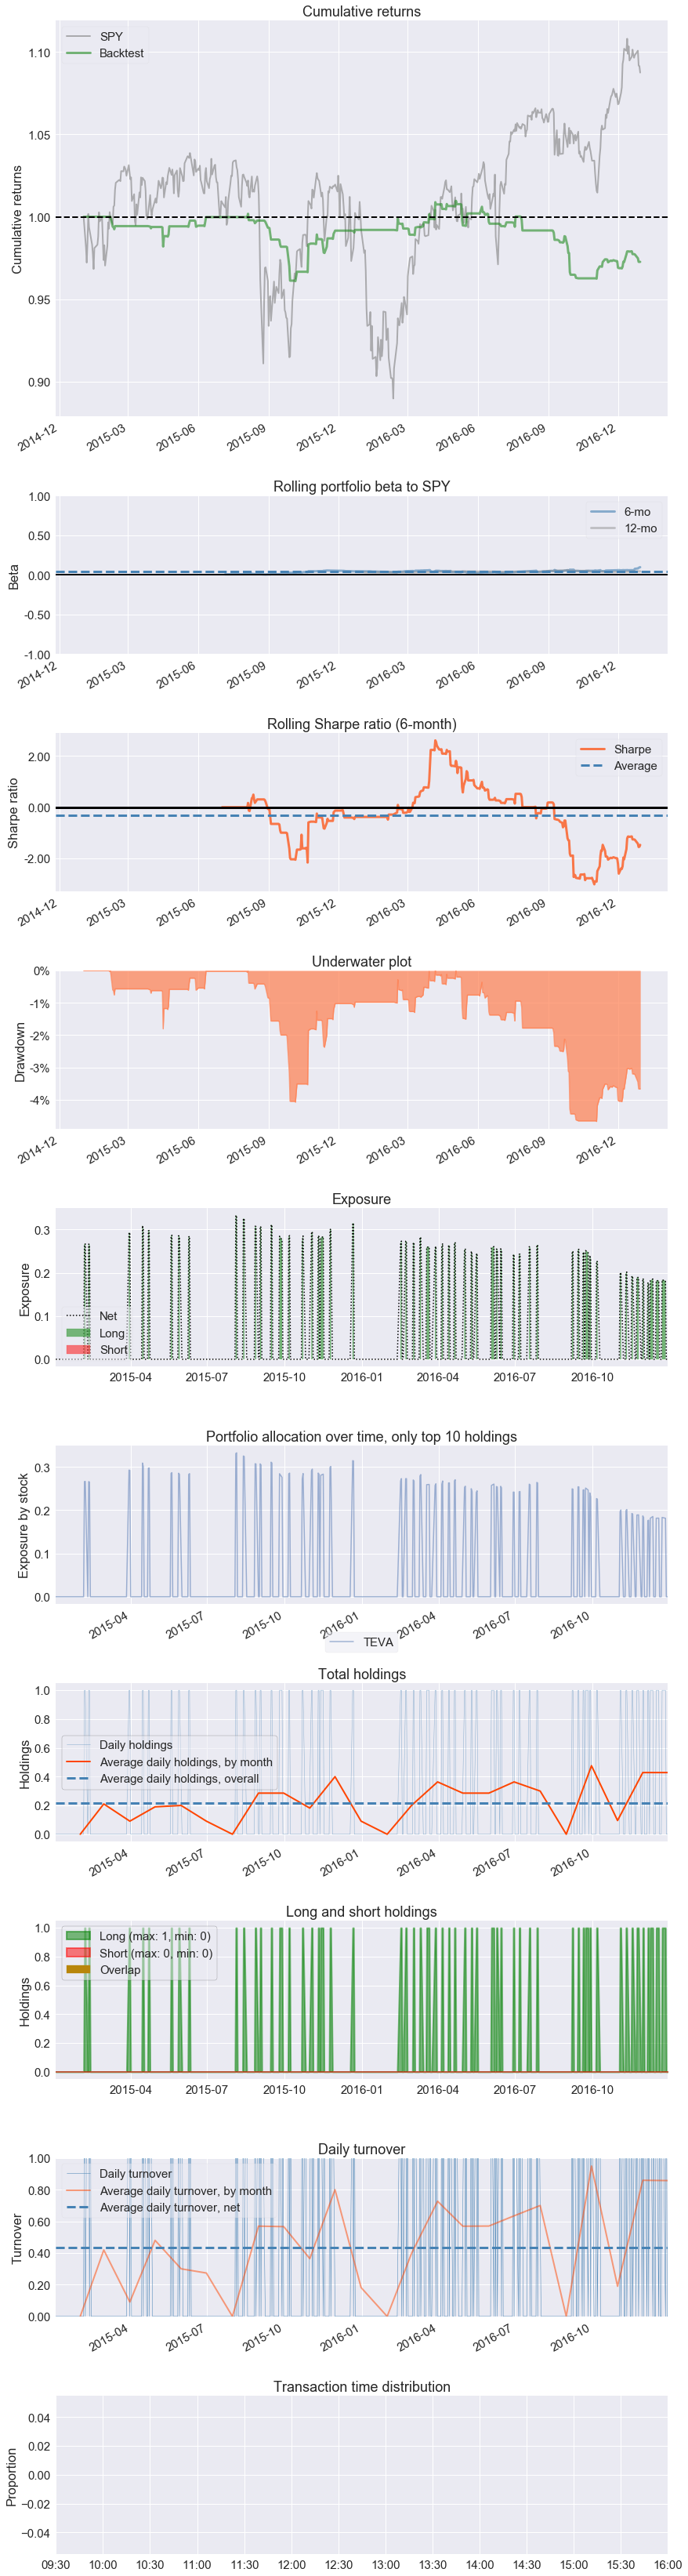

In [274]:
if not transactions.empty:
    pf.create_simple_tear_sheet(returns=returns, 
                                positions=positions, 
                                transactions=transactions)

# Portfolio testing

In [276]:
tickers_list = 'AAL AAPL ADBE ADI ADP ADSK AKAM ALXN AMAT AMGN AMZN ATVI AVGO BBBY BIDU BIIB BMRN CA'.split(' ')

In [279]:
for tick in tickers_list:
    print('Current ticker:', tick)
    cerebro = bt.Cerebro()

    data = bt.feeds.YahooFinanceData(
        dataname=tick,
        fromdate=from_date,
        todate=to_date,
        reverse=False)

    cerebro.adddata(data)
    cerebro.addstrategy(TestStrategy)

    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)
    #cerebro.addsizer(bt.sizers.PercentSizer, percents=50)
    cerebro.addsizer(bt.sizers.FixedSize, stake=500)

    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    #cerebro._doreplay=True
    results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    strat = results[0]
    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    
    if not transactions.empty:
        pf.create_simple_tear_sheet(returns=returns, 
                                    positions=positions, 
                                    transactions=transactions)

Current ticker: AAL
Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2016-12-30, '2016-12-29'
Final Portfolio Value: 100000.00
Current ticker: AAPL
Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2016-12-30, '2016-12-29'
Final Portfolio Value: 100000.00
Current ticker: ADBE
Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2016-12-30, '2016-12-29'
Final Portfolio Value: 100000.00
Current ticker: ADI
Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2016-12-30, '2016-12-29'
Final Portfolio Value: 100000.00
Current ticker: ADP
Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2016-12-30, '2016-12-29'
Final Portfolio Value: 100000.00
Current ticker: ADSK
Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2016-12-30, '2016-12-29'
Final Portfolio Value: 100000.00
Current ticker: AKAM
Starting Portfolio Value: 100000.00
2015-01-02, '2016-12-30'
2016-12-30, '2016-12-29'
Final Portfolio Value: 100000.00
Current ticker: ALXN
St